# Imports and Configs

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import pprint as pp
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

In [2]:
# conda install -c conda-forge jpype1
from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/Users/gilmar/opensource/jidt/demos/python")
import readFloatsFile

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/Users/gilmar/opensource/jidt/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

# Utility Functions

Prints stats from dataframe or timeseries

In [3]:
def inspect_df(df, txt='Dataframe Information', date_col='date', timeseries=False, col_prefix=None, sep_size=80):
    print('=' * sep_size)
    print(txt)
    print('=' * sep_size)
    date_range_counts_label = 'Dates Range and Row Count'
    print(date_range_counts_label)
    print('-' * len(date_range_counts_label))
    agg_df =  df
    date_col = col_prefix + date_col if col_prefix else date_col
    if not timeseries:
        agg_df =  df[date_col]
    pp.pprint(agg_df.agg(['min','max','count']))
    print('-' * sep_size)
    pp.pprint(df.info())

Given a timeseries, applies a logarithmic transformation and computes the difference between consecutive log-transformed values.

In [4]:
def log_difference(series):
    log_series = np.log(series)
    log_diff_series = log_series.diff().dropna()
    return log_diff_series

Performs the [Augmented Dickey-Fuller (ADF)](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) test on the log differenced series.

In [5]:
def dickey_fuller_test_stationarity(series):
    result = adfuller(series)
    p_value = result[1]
    return "stationary" if p_value < 0.05 else "non-stationary"

Compute result and statistical significancy

In [44]:
def compute_estimate_and_stat_sig(source, destination, calc, surrogate_perms=100, conditional=None):
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    if conditional:
        calc.setObservations(source, destination, conditional)
    else:
        calc.setObservations(source, destination)
    
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    # 6. Compute the (statistical significance via) null distribution empirically (e.g. with 1000 permutations):
    measDist = calc.computeSignificance(surrogate_perms)
    return result, measDist

Run a grid search for best k and time lag given a source and destination series and a calculator

In [32]:
def grid_search_k_timediff(source, destination, calc, surrogate_perms=100):
    results = []
    time_diffs = range(0,30)
    ks = range(4,6)

    for time_diff in time_diffs:
        for k in ks:
            # Set TIME_DIFF and k properties
            calc.setProperty("TIME_DIFF", str(time_diff))
            calc.setProperty("k", str(k))
            result, measDist = compute_estimate_and_stat_sig(source, destination, calc, surrogate_perms)
            results.append([time_diff,k,result,measDist.pValue])
    
    grid_search_results_df = pd.DataFrame(results)
    grid_search_results_df.columns = ['time_diff','k', 'mi_nats', 'p_value']
    
    return grid_search_results_df

Extract best mutual information from grid search result

In [33]:
def extract_best_result(grid_search_results_df):
    return grid_search_results_df.iloc[grid_search_results_df['mi_nats'].idxmax()]

# Inspect Initial Data

In [34]:
elon_doge_df = pd.read_csv('data/tweets_doge_bitcoin.csv')
elon_doge_df['date'] = pd.to_datetime(elon_doge_df.date)
elon_doge_df = elon_doge_df.set_index('date')

In [35]:
inspect_df(elon_doge_df, timeseries=True)

Dataframe Information
Dates Range and Row Count
-------------------------
       bitcoin_close  bitcoin_volume  dogecoin_close  dogecoin_volume  \
min          3211.72     1254.292531        0.001038          1431720   
max         67525.83   760705.362783        0.684777      69410680685   
count        2059.00     2059.000000     2059.000000             2059   

       dogecoin_mentions  dogecoin_mention_polarity_score  
min                  0.0                          -0.5106  
max                  4.0                           1.6413  
count             2059.0                        2059.0000  
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2059 entries, 2017-11-09 to 2023-06-29
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   bitcoin_close                    2059 non-null   float64
 1

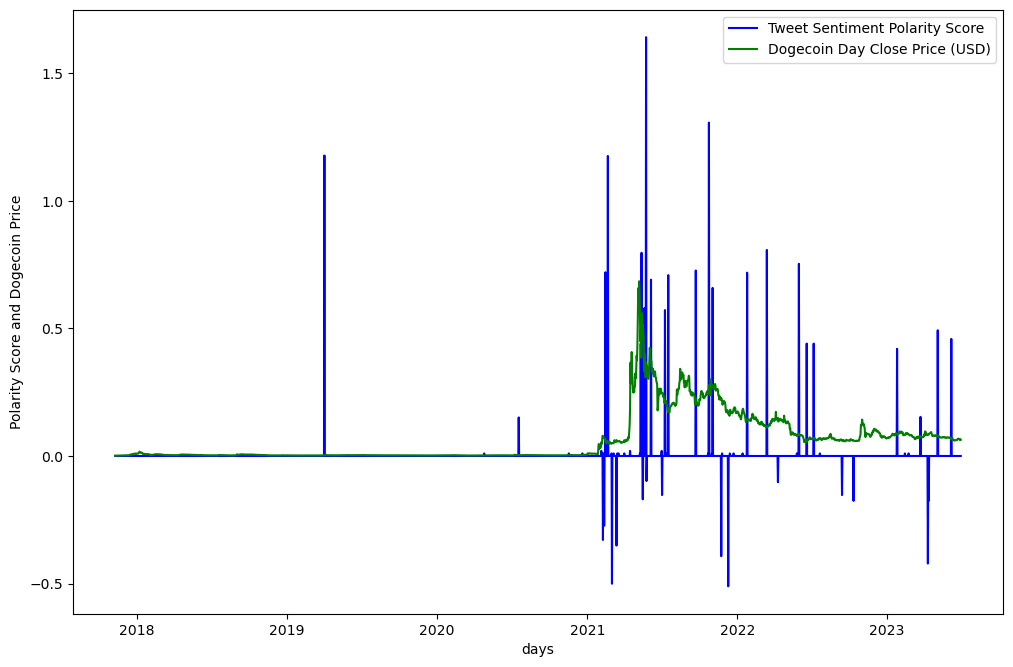

In [24]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(elon_doge_df.index, elon_doge_df['dogecoin_mention_polarity_score'].values\
         , color='blue', label='Tweet Sentiment Polarity Score')
plt.plot(elon_doge_df.index, elon_doge_df['dogecoin_close'].values\
         , color='green', label='Dogecoin Day Close Price (USD)')
plt.xlabel('days')
plt.ylabel('Polarity Score and Dogecoin Price')
plt.legend()

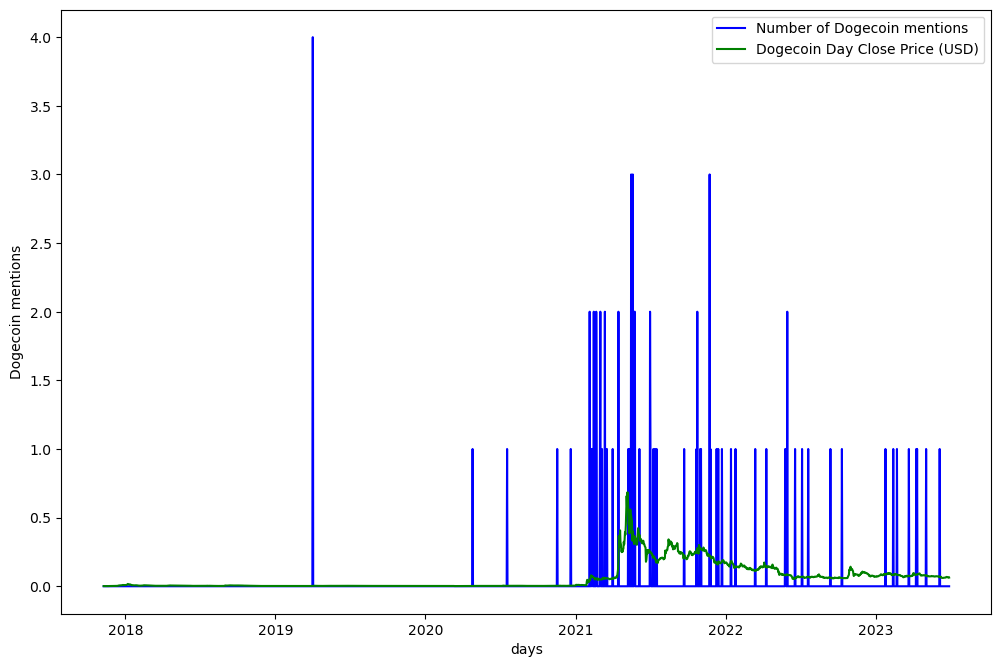

In [25]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(elon_doge_df.index, elon_doge_df['dogecoin_mentions'].values\
         , color='blue', label='Number of Dogecoin mentions')
plt.plot(elon_doge_df.index, elon_doge_df['dogecoin_close'].values\
         , color='green', label='Dogecoin Day Close Price (USD)')
plt.xlabel('days')
plt.ylabel('Dogecoin mentions')
plt.legend()

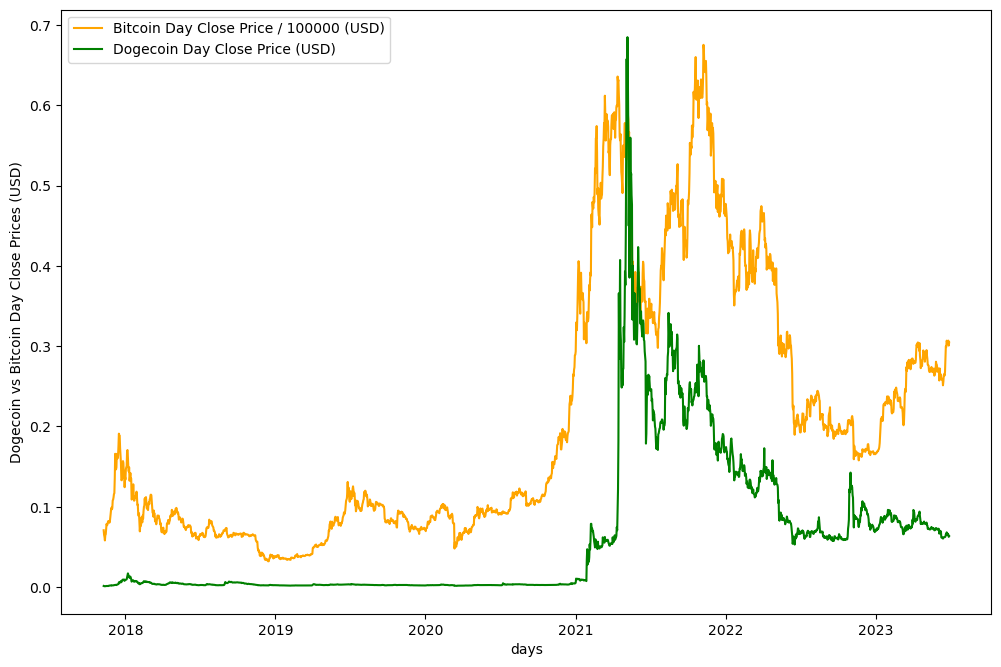

In [26]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(elon_doge_df.index, (elon_doge_df['bitcoin_close'].values / 100000)\
         , color='orange', label='Bitcoin Day Close Price / 100000 (USD)')
plt.plot(elon_doge_df.index, elon_doge_df['dogecoin_close'].values\
         , color='green', label='Dogecoin Day Close Price (USD)')
plt.xlabel('days')
plt.ylabel('Dogecoin vs Bitcoin Day Close Prices (USD)')
plt.legend()

# Information Theory Analysis

## Mentions Score vs Dogecoin Price MI

In [27]:
# 0. Load/prepare the data:
dataRaw = readFloatsFile.readFloatsFile("data/mensions_doge_bitcoin_close.txt")
# As numpy array:
data = numpy.array(dataRaw)

### Controlling for autocorrelations

Metions autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

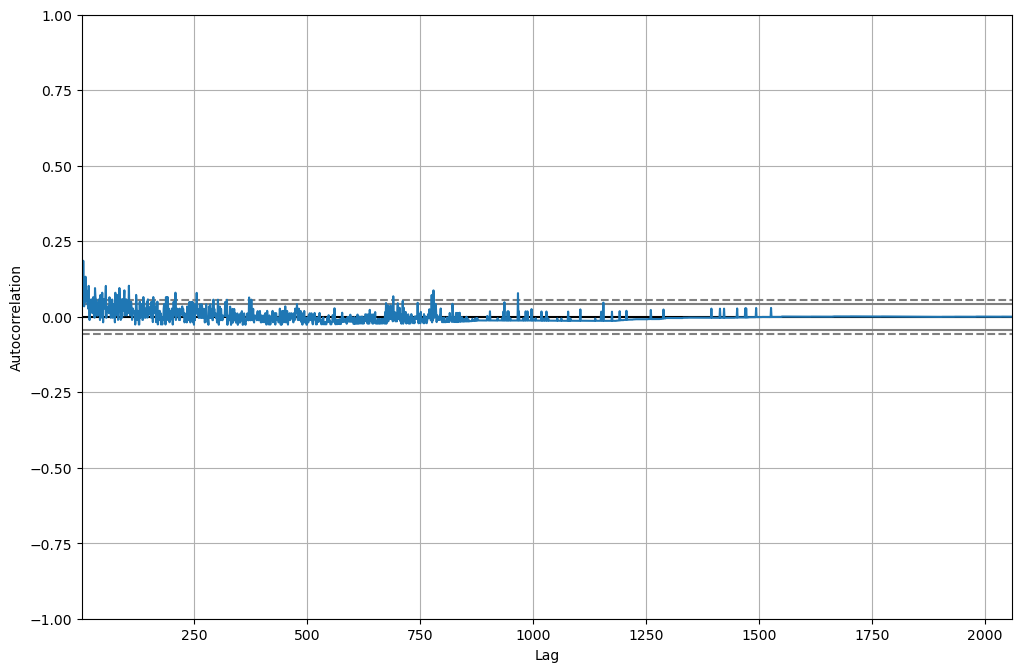

In [28]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
pd.plotting.autocorrelation_plot(data[:,0])

Dogecoin close value autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

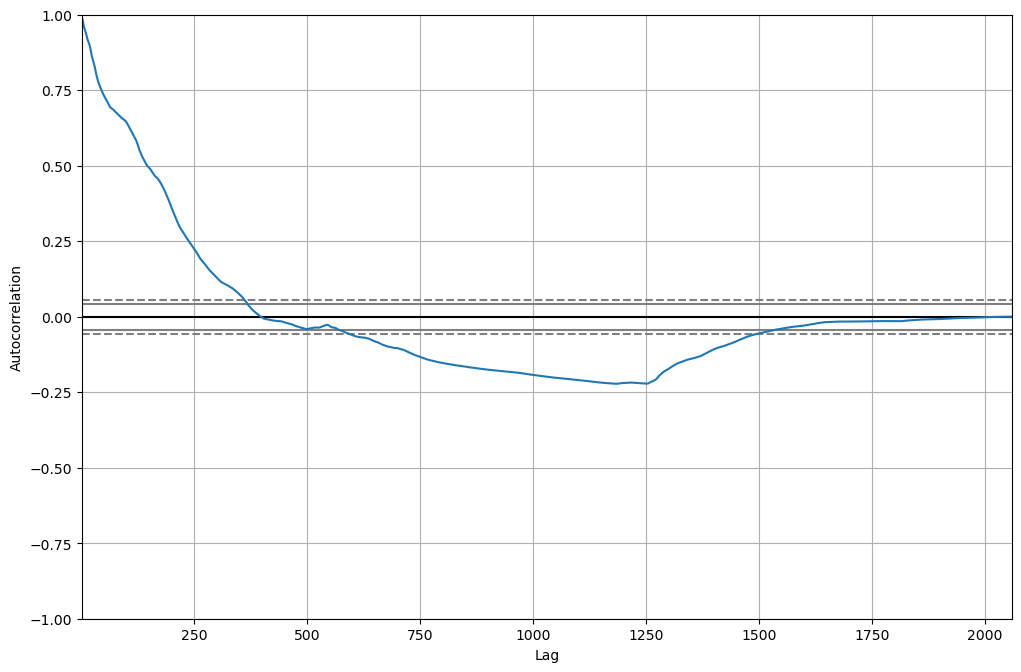

In [29]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
pd.plotting.autocorrelation_plot(data[:,1])

The dogecoin close value remains significantly autocorrelated until a lag of about 300

### KSG Grid Search for k and time diff

In [36]:
source = JArray(JDouble, 1)(data[:,0].tolist())
destination = JArray(JDouble, 1)(data[:,1].tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1
calc = calcClass()
calc.setProperty("DYN_CORR_EXCL", "300")

In [37]:
grid_search_results_df = grid_search_k_timediff(source, destination, calc, surrogate_perms=1000)

In [38]:
extract_best_result(grid_search_results_df)

time_diff    16.000000
k             5.000000
mi_nats       0.359409
p_value       0.000000
Name: 33, dtype: float64

Text(0, 0.5, 'MI (nats)')

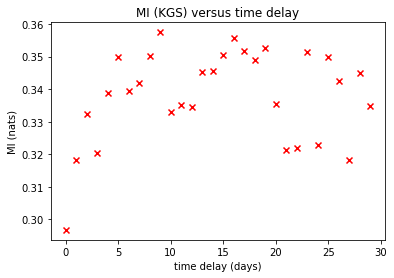

In [39]:
timediff_results_df = grid_search_results_df[grid_search_results_df.k == 4] 
plt.figure();
plt.scatter(timediff_results_df.time_diff, timediff_results_df.mi_nats, c='red', marker='x');
plt.title('MI (KGS) versus time delay')
plt.xlabel('time delay (days)')
plt.ylabel('MI (nats)')

Text(0, 0.5, 'frequency')

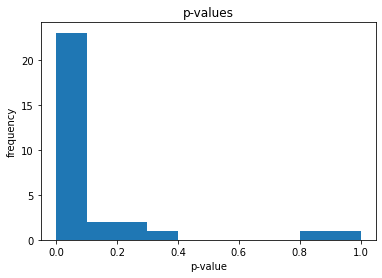

In [40]:
timediff_results_df.p_value.plot.hist()
plt.title('p-values')
plt.xlabel('p-value')
plt.ylabel('frequency')

In [47]:
# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("TIME_DIFF", "14")
calc.setProperty("DYN_CORR_EXCL", "300")

result, measDist = compute_estimate_and_stat_sig(source, destination, calc, 10000)


print("MI_Kraskov (KSG) alg. 1(col_0 -> col_1) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, 10000))

MI_Kraskov (KSG) alg. 1(col_0 -> col_1) = 0.3456 nats (null: 0.3183 +/- 0.0030 std dev.; p(surrogate > measured)=0.00000 from 10000 surrogates)


## Conditional on Bitcoin close value

Text(0.5, 1.0, 'Bitcoin Autocorrelation')

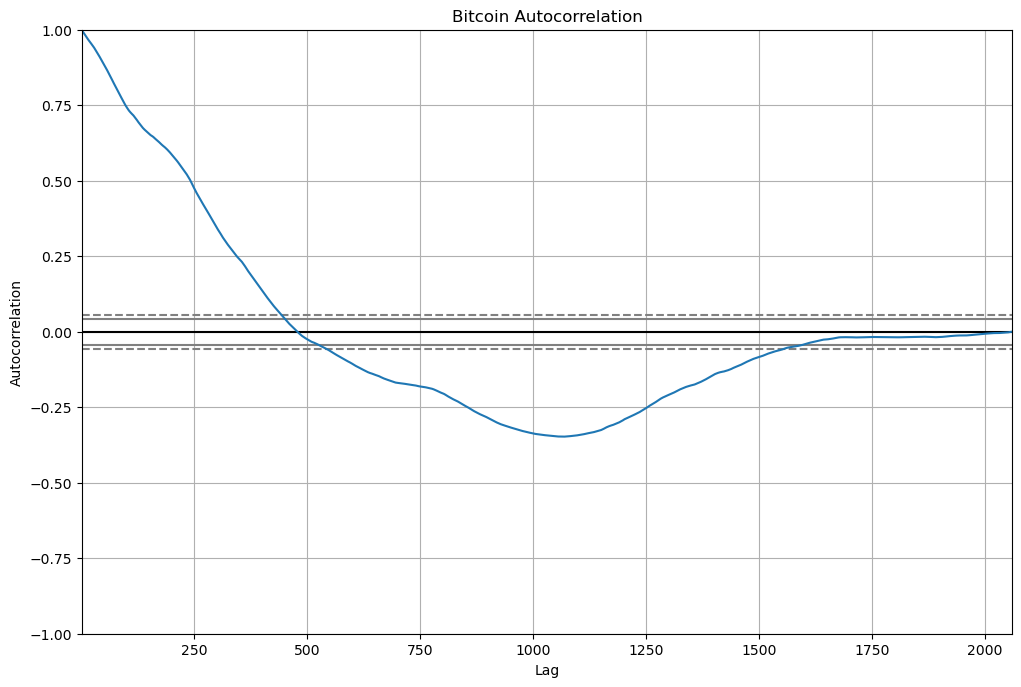

In [48]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
pd.plotting.autocorrelation_plot(data[:,2])
plt.title('Bitcoin Autocorrelation')

In [49]:
source = JArray(JDouble, 1)(data[:,0].tolist())
destination = JArray(JDouble, 1)(data[:,1].tolist())
conditional = JArray(JDouble, 1)(data[:,2].tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").ConditionalMutualInfoCalculatorMultiVariateKraskov1
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("DYN_CORR_EXCL", "450")


result, measDist = compute_estimate_and_stat_sig(source, destination, calc, 10000, conditional)

print("CMI_Kraskov (KSG) alg. 1(col_0 -> col_1 | col_2) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, 10000))


CMI_Kraskov (KSG) alg. 1(col_0 -> col_1 | col_2) = 0.0009 nats (null: -0.0004 +/- 0.0129 std dev.; p(surrogate > measured)=0.55230 from 10000 surrogates)


# Mentions Score vs Bitcoin Price MI

In [50]:
source = JArray(JDouble, 1)(data[:,0].tolist())
destination = JArray(JDouble, 1)(data[:,2].tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1
calc = calcClass()
calc.setProperty("DYN_CORR_EXCL", "450")


grid_search_results_df = grid_search_k_timediff(source, destination, calc, surrogate_perms=1000)

# Dogecoin vs Bitcoin Price MI

In [51]:
source = JArray(JDouble, 1)(data[:,1].tolist())
destination = JArray(JDouble, 1)(data[:,2].tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1
calc = calcClass()
calc.setProperty("DYN_CORR_EXCL", "450")

grid_search_results_df = grid_search_k_timediff(source, destination, calc, surrogate_perms=1000)

In [52]:
extract_best_result(grid_search_results_df)

time_diff    0.000000
k            5.000000
mi_nats      0.924438
p_value      0.000000
Name: 1, dtype: float64

In [57]:
surrogates = 1000

result, measDist = compute_estimate_and_stat_sig(source, destination, calc, surrogates)

print("MI_Kraskov (KSG) alg. 1(col_1 -> col_2) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, surrogates))

MI_Kraskov (KSG) alg. 1(col_1 -> col_2) = 0.7198 nats (null: 0.5075 +/- 0.0187 std dev.; p(surrogate > measured)=0.00000 from 1000 surrogates)


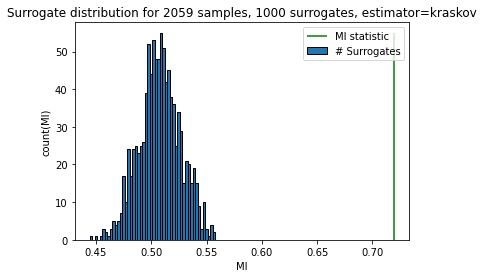

In [58]:
surrogates_hist, hist_edges = numpy.histogram(numpy.array(measDist.distribution), bins=50)

# hist_edges has the lower and upper edge of each bin, so has length 51. Just pass the first 50 items as the x coordinates,
#  and tell plt.bar to align the bars to the left edge. The bar width is the difference between the edges.
plt.bar(hist_edges[:-1], surrogates_hist, width=numpy.diff(hist_edges), align='edge', ec='black', label='# Surrogates');
plt.vlines(x=result, ymin=0, ymax=numpy.max(surrogates_hist), colors='green', label='MI statistic');  # Mark in our measured MI
plt.legend()
# Now add a nice title to the plot
calcName = calcClass.__name__;
calcName = calcName[calcName.index('continuous.') + len('continuous.'):calcName.index('.MutualInfo')]
plt.title('Surrogate distribution for %d samples, %d surrogates, estimator=%s' % (len(source), surrogates, calcName));
plt.xlabel('MI')
plt.ylabel('count(MI)');